# **Predicting Fire Radiative Power Using Random Forest Regressor**



## **Introduction**

This notebook explores the prediction of Fire Radiative Power (FRP) using satellite data of Australian bushfires with a Random Forest Regressor. The goal of this notebook is to predict the intensity of wildfires based on features like brightness values (`bright_ti4` and `bright_ti5`), geographical coordinates, and confidence levels. The analysis covers data preprocessing, feature selection, model training, and evaluation.

## **Importing Required Libraries**

The following libraries are essential for data processing, model training, and visualisation:

- **`os`**: Handles file paths and directories.
- **`pandas`**: Used for data manipulation and analysis.
- **`numpy`**: Core library for numerical computing.
- **`matplotlib.pyplot`**: Creates static visualisations, like plots and charts.
- **`seaborn`**: Built on `matplotlib`, provides high-level statistical graphics.
- **`sklearn.ensemble.RandomForestRegressor`**: Random Forest model for handling non-linear relationships.
- **`sklearn.model_selection.train_test_split`**: Splits the dataset into training and testing subsets.
- **`sklearn.metrics`**: Provides performance metrics like MSE and R² score.
- **`geopandas`**: Handles geographic data for plotting maps of Australia.
- **`matplotlib.colors`**: Manages colour normalisation for visualisations.

In [48]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import geopandas as gpd
import matplotlib.colors as mcolors

## **Loading and Examining the Dataset**

In this step, the dataset will be loaded into a Pandas DataFrame and displayed using some simple dataset visaulation techniques

1. Load the dataset using `pd.read_csv()`.
2. Examine the structure of the data with `df.info()` to check for any missing values and to get an overview of the column types.
3. Preview the first few rows using `df.head()` to get an initial look at the data and understand its content.

In [49]:
# Load the dataset (your own filename or path may be different)
dataset_path = "/Users/ciaranbritton/Library/Mobile Documents/com~apple~CloudDocs/Ciaran's Folder/University/Year 4/Advanced Computational Techniques/bushfires.csv"
df = pd.read_csv(dataset_path)

In [50]:
# Display information on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105713 entries, 0 to 105712
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   latitude    105713 non-null  float64
 1   longitude   105713 non-null  float64
 2   bright_ti4  105713 non-null  float64
 3   scan        105713 non-null  float64
 4   track       105713 non-null  float64
 5   acq_date    105713 non-null  object 
 6   acq_time    105713 non-null  int64  
 7   satellite   105713 non-null  object 
 8   instrument  105713 non-null  object 
 9   confidence  105713 non-null  object 
 10  version     105713 non-null  int64  
 11  bright_ti5  105713 non-null  float64
 12  frp         105713 non-null  float64
 13  type        105713 non-null  int64  
dtypes: float64(7), int64(3), object(4)
memory usage: 11.3+ MB


In [51]:
# Display the first rows of each column
df.head()

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,type
0,-37.48861,149.63156,341.1,0.41,0.60,2019-09-01,304,N,VIIRS,n,1,293.7,4.4,0
1,-34.46110,150.88142,328.5,0.33,0.55,2019-09-01,305,N,VIIRS,l,1,298.5,2.1,2
2,-33.94823,151.21292,341.1,0.62,0.54,2019-09-01,305,N,VIIRS,n,1,295.3,6.4,0
3,-34.45618,150.87723,328.5,0.33,0.55,2019-09-01,305,N,VIIRS,n,1,298.1,2.1,2
4,-31.60223,150.15147,367.0,0.34,0.56,2019-09-01,306,N,VIIRS,h,1,302.4,19.3,0


### **Dataset Overview**

After loading the dataset, we can see the following:

- **Satellite, Instrument, and Version Columns**: These columns don't change throughout the dataset as they describe static variables.
- **acq_date**: The acquisition date stays within the same month for all observations.
- **bright_ti4 and bright_ti5**: These columns represent the brightness values of the fire in different infrared bands. They provide information about the intensity of the fire, which will be crucial for predicting Fire Radiative Power (FRP).
- **frp**: This is our target continuous variable. FRP represents the intensity of the fire and is the variable we aim to predict using the features from the dataset.
- **type**: This column is meant to display whether the readings were taken during the day or night, however the column only displays the numbers 0, 2, or 3. Either way this variable wouldn't have impacted our target varaible considerably enough to worry about.
- **confidence**: This column represents the confidence level of the measurements, either low, nominal, or high.
- **latitude and longitude**: These columns indicate the geographical coordinates of each fire event.
- **scan and track**: These columns represent the pixel size in the scan and track directions of the satellite’s observation. `Scan` refers to the pixel size along the satellite's movement across the Earth's surface, while `track` refers to the pixel size along the satellite's orbit path.

## **Data Preprocessing**

- **Dropping unnecessary columns**: Remove irrelevant columns for analysis.
- **One-hot encoding `confidence`**: Convert the categorical `confidence` column into binary columns.
- **Filtering low-confidence rows**: Remove rows with low-confidence data.
- **Capping FRP outliers**: Limit FRP values to the 95th percentile to handle extreme outliers.
- **Removing missing values**: Drop rows with any remaining missing values.

In [52]:
# Drop unnecessary columns that aren't needed for the analysis
df_cleaned = df.drop(columns=["instrument", "version", "satellite", "acq_date"])

# One-hot encode the 'confidence' column to convert categorical values into binary columns
df_cleaned = pd.get_dummies(df_cleaned, columns=["confidence"], prefix="confidence")

# Filter out low-confidence rows where the 'confidence_l' column equals 1 (low confidence)
if "confidence_l" in df_cleaned.columns:
    df_cleaned = df_cleaned[df_cleaned["confidence_l"] == 0]  # Keep only nominal or high confidence
    df_cleaned = df_cleaned.drop(columns=["confidence_l"])  # Drop the low-confidence column

# Cap the FRP values at the 95th percentile to remove extreme outliers
frp_95th = df_cleaned["frp"].quantile(0.95)
df_cleaned["frp_capped"] = df_cleaned["frp"].clip(upper=frp_95th)

# Remove rows with missing values to ensure a clean dataset for training
df_cleaned = df_cleaned.dropna()

In [53]:
# Save the cleaned dataset to a new CSV file (will be used later in future questions to save time re-cleaning)
df_cleaned.to_csv("/Users/ciaranbritton/Library/Mobile Documents/com~apple~CloudDocs/Ciaran's Folder/University/Year 4/Advanced Computational Techniques/cleaned_bushfires.csv", index=False)

After preprocessing the data, the cleaned dataset will be displayed again, including a summary of the dataset (`info`) and the first few rows (`head`) to confirm the changes and ensure that the data is ready for model training.

In [54]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98514 entries, 0 to 105712
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      98514 non-null  float64
 1   longitude     98514 non-null  float64
 2   bright_ti4    98514 non-null  float64
 3   scan          98514 non-null  float64
 4   track         98514 non-null  float64
 5   acq_time      98514 non-null  int64  
 6   bright_ti5    98514 non-null  float64
 7   frp           98514 non-null  float64
 8   type          98514 non-null  int64  
 9   confidence_h  98514 non-null  bool   
 10  confidence_n  98514 non-null  bool   
 11  frp_capped    98514 non-null  float64
dtypes: bool(2), float64(8), int64(2)
memory usage: 8.5 MB


In [55]:
df_cleaned.head()

,latitude,longitude,bright_ti4,scan,track,acq_time,bright_ti5,frp,type,confidence_h,confidence_n,frp_capped
0,-37.48861,149.63156,341.1,0.41,0.60,304,293.7,4.4,0,False,True,4.4
2,-33.94823,151.21292,341.1,0.62,0.54,305,295.3,6.4,0,False,True,6.4
3,-34.45618,150.87723,328.5,0.33,0.55,305,298.1,2.1,2,False,True,2.1
4,-31.60223,150.15147,367.0,0.34,0.56,306,302.4,19.3,0,True,False,19.3
5,-29.26867,149.46602,367.0,0.35,0.57,306,307.0,13.6,0,True,False,13.6


## **Data Visualisation - Fire Locations and FRP Over a Map of Australia**

To get a better idea of what these data points actually show, this part visualises fire locations across Australia and their FRP. The fire locations will be plotted on a map and colour-coded by FRP values using a log scale to show the intensity of the fires. This provides insights into the spatial distribution and intensity of the fires.

This notebook is using a map of Australia provided by Natural Earth data. The shapefile can be downloaded through this link in Admin 0 - Countries: https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

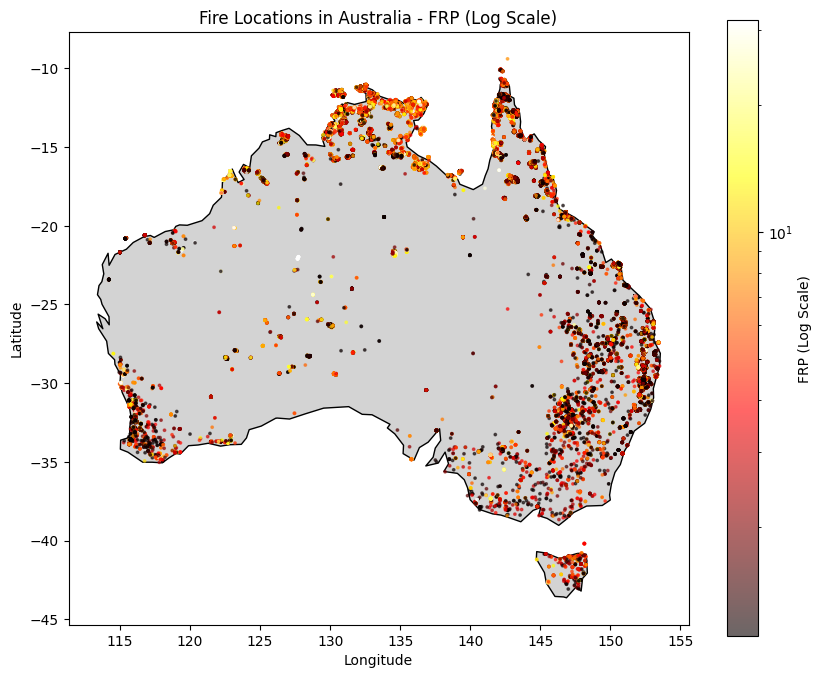

In [56]:
# Load the countries shapefile
shapefile_path = "/Users/ciaranbritton/Library/Mobile Documents/com~apple~CloudDocs/Ciaran's Folder/University/Year 4/Advanced Computational Techniques/ne_110m_admin_0_countries"
world = gpd.read_file(shapefile_path)

# Filter for Australia
australia = world[world["ADMIN"] == "Australia"]

# Plot fire locations with FRP colour mapping
norm = mcolors.LogNorm(vmin=df_cleaned["frp_capped"].min() + 1, vmax=df_cleaned["frp_capped"].max())

fig, ax = plt.subplots(figsize=(10, 8))
australia.plot(ax=ax, color="lightgrey", edgecolor="black")
sc = ax.scatter(
    df_cleaned["longitude"], df_cleaned["latitude"],
    c=df_cleaned["frp_capped"], cmap="hot", norm=norm, alpha=0.6, s=3
)
plt.colorbar(sc, ax=ax, label="FRP (Log Scale)")
plt.title("Fire Locations in Australia - FRP (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## **Features, Target Variable and Train-Test Split**
For our dataset, the most important features for predicting FRP are:

*   `bright_ti4`
*   `bright_ti5`
*   `latitude`
*   `longitude`
*   `scan`
*   `track`




And as previously mentioned, FRP will be our target variable.



---





- **Training Set**: The training set is used to teach the model, i.e., to adjust the internal parameters of the model based on the input data and the target labels.
- **Test Set**: The test set is used to evaluate the performance of the trained model. It contains data that the model has never seen before, allowing us to assess how well it can make predictions on new, unseen data.

The 80-20 split is a common convention. In this split:
- **80%** of the data is used for training the model, ensuring the model has enough data to learn from.
- **20%** of the data is reserved for testing, which allows us to get an unbiased estimate of the model's performance.

`train_test_split` is used from **scikit-learn** to randomly divide the data into two sets. This function shuffles the data before splitting, ensuring the distribution of the data is randomised.

In [57]:
# Define features and target variable from cleaned dataset. Redefine them as 'X' for the features and 'y' for the target varaible
features = ["bright_ti4", "bright_ti5", "latitude", "longitude", "scan", "track"]
X = df_cleaned[features]
y = df_cleaned["frp_capped"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Training the Random Forest Model**

### Random Forest Regressor
A Random Forest is an ensemble learning method, which means it combines the predictions of multiple individual models (in this case, decision trees) to improve the accuracy and robustness of predictions. Random Forests are widely used in regression tasks due to their ability to handle complex datasets and provide high accuracy.

Each individual tree in the random forest is trained on a random subset of the data, and when making predictions, the Random Forest averages the predictions from all the trees, resulting in a more reliable outcome. This approach reduces the risk of overfitting that might occur with a single decision tree.

### Why is a Random Forest Regressor optimal for this problem?
- **Handling Complex Data**: The dataset includes a mix of continuous and categorical variables, and Random Forests are well-suited to handle such complex datasets.
- **Robustness**: By averaging the predictions from multiple trees, Random Forests reduce the variance and increase the model's robustness, which is crucial for ensuring reliable predictions on new, unseen data.

### Training the Model
Using the **scikit-learn** library, we initialise a **RandomForestRegressor** and fit it to the training data. This means that the model learns from the input features (`X_train`) and the corresponding target variable (`y_train`).

### Parameters:
- **`n_estimators`**: This parameter specifies the number of decision trees in the forest. A higher value typically leads to better performance, as more trees reduce the variance, but it also increases the computational cost.
- **`random_state`**: This is used to ensure reproducibility. Setting a fixed value for `random_state` ensures that the results are the same every time the code is run, which is useful for consistent comparisons across experiments. The number 42 is commonly used in data science for a random state.

In [58]:
# Train the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## **Evaluating the Model**

1. **Mean Squared Error (MSE)**:
   - MSE measures the average of the squares of the errors, i.e., the average squared difference between the actual values and the predicted values. The formula for MSE is:
   $MSE = \frac{1}{n} \sum (y_{\text{true}} - y_{\text{pred}})^2$
   A lower MSE indicates better model performance, as it means the model's predictions are closer to the actual values.

2. **Root Mean Squared Error (RMSE)**:
   - RMSE is the square root of MSE and provides an error measurement in the same unit as the target variable (FRP in this case). A lower RMSE suggests better model accuracy.
$RMSE = \sqrt{MSE}$

3. **R-squared (R²) Score**:
   - R² indicates how well the model fits the data. It measures the proportion of the variance in the dependent variable (FRP) that is predictable from the independent variables. The R² value ranges from 0 to 1, where:
     - **1** means the model perfectly predicts the target variable.
     - **0** means the model performs no better than simply predicting the mean of the target variable.
   - A higher R² score indicates a better fit of the model to the data.

In [59]:
# Predictions
y_pred = rf.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Random Forest Results:")
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

Random Forest Results:
MSE: 25.13, RMSE: 5.01, R²: 0.63


Here we can see our model has fairly low errors, but the R² score is relatively low. This doesn't mean that the model is poor as R² is not a measure of accuracy, it just shows that some of the predicted points deviate away from the test set.

## **Feature Importance**

In the feature importance plot, we visualize how much each feature contributes to reducing the error in the model's predictions. Random Forest models calculate feature importance by evaluating how much each feature improves the predictive power of the model during training.

For example, in our model, we are interested in understanding which factors, such as brightness, most strongly influence the FRP predictions.

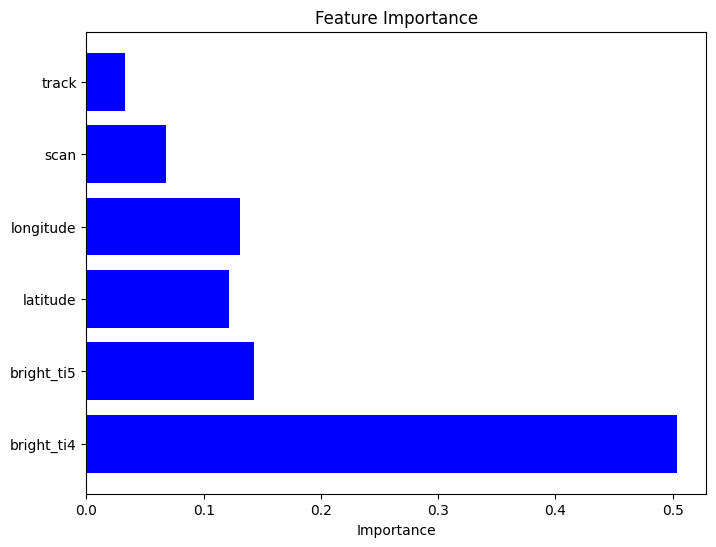

In [60]:
# Feature Importance
feature_importances = rf.feature_importances_
plt.figure(figsize=(8, 6))
plt.barh(features, feature_importances, color="blue")
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.show()

## **Visualising Model Performance**

This section explores the model's performance and the relationships between features and the target variable (FRP).

### 1. Actual vs Predicted FRP (Scatter Plot)
The scatter plot compares actual FRP values to predicted values. Each point represents a test data point, with the x-axis showing actual values and the y-axis showing predicted values. The red dashed line represents a perfect prediction. The closer the points are to this line, the better the model's performance. Even though FRP was capped at 95%, it still looks like there are some more extreme outliers as the model did poorly when trying to predict those values.

### 2. Histogram of Prediction Errors
The histogram of prediction errors helps evaluate the error distribution. Ideally, the errors should be symmetrically distributed around zero, indicating unbiased predictions. A skewed error distribution suggests potential issues with the model.

### 3. Distribution of Actual vs Predicted FRP
This plot compares the distributions of the actual and predicted FRP values. The blue bars represent the actual values, and the orange bars represent the predicted values, along with their respective Kernel Density Estimates (KDEs). The actual FRP distribution shows a heavy concentration of lower values, with a few extreme outliers at the high end. The predicted values follow a similar trend, but there are discrepancies in the high-intensity fire areas. This highlights the model's struggles with predicting extreme fire intensities.

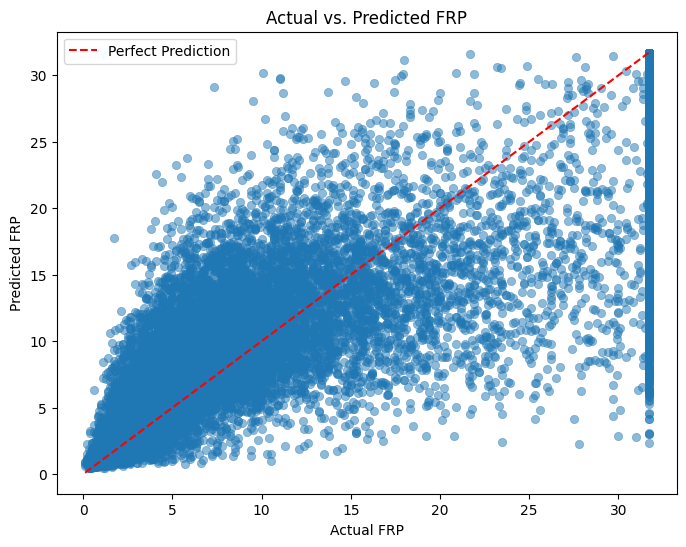

In [61]:
# Scatter plot: Actual vs. Predicted FRP
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual FRP")
plt.ylabel("Predicted FRP")
plt.title("Actual vs. Predicted FRP")
plt.legend()
plt.show()

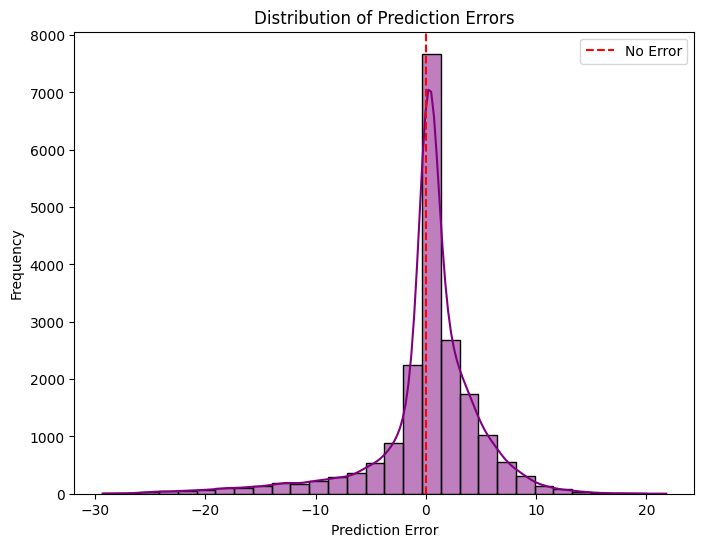

In [62]:
# Histogram of Prediction Errors
prediction_errors = y_pred - y_test
plt.figure(figsize=(8, 6))
sns.histplot(prediction_errors, bins=30, kde=True, color="purple")
plt.axvline(x=0, linestyle="--", color="red", label="No Error")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.legend()
plt.show()

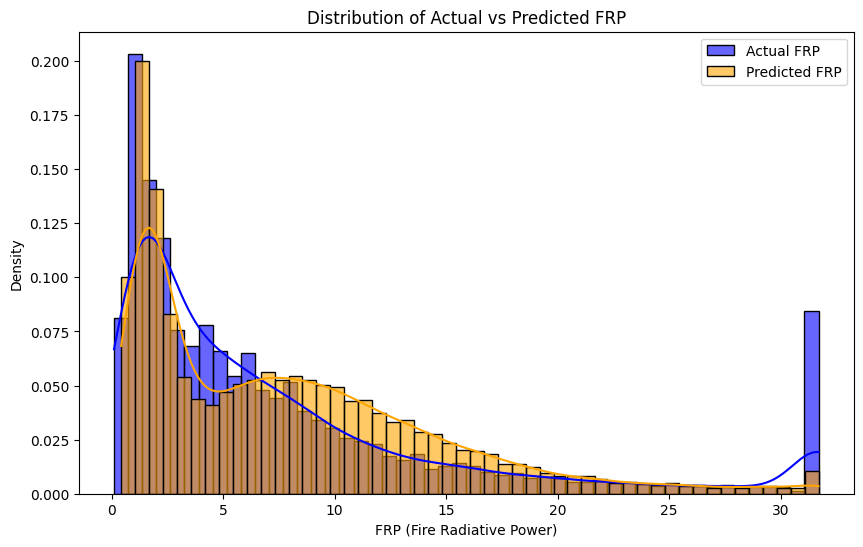

In [63]:
# Actual vs predicted FRP as histograms
plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=50, color="blue", kde=True, stat="density", label="Actual FRP", alpha=0.6)
sns.histplot(y_pred, bins=50, color="orange", kde=True, stat="density", label="Predicted FRP", alpha=0.6)

plt.legend()
plt.title("Distribution of Actual vs Predicted FRP")
plt.xlabel("FRP (Fire Radiative Power)")
plt.ylabel("Density")
plt.show()